Mounted at /content/drive
Data shape: (1048575,)


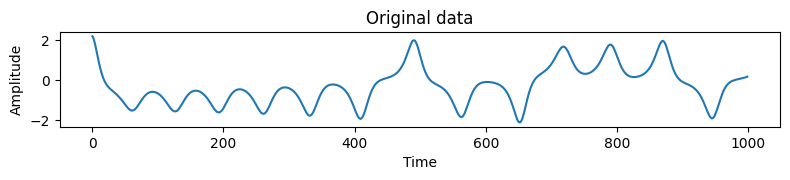

In [1]:
# @title Data loading and standardization

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/lorentz_long_x.csv'


import pandas as pd
import numpy as np

data = pd.read_csv(file_path)
data = np.array(data)

import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import datetime
import networkx as nx
import csv

nan_indices = np.where(np.isnan(data))
data = np.delete(data, nan_indices)

#Standardization

mean_value = np.mean(data)
std_dev = np.std(data)
data = (data - mean_value) / std_dev


print('Data shape:',data.shape)

# Visualization
plt.figure(figsize=(8, 3))

plt.subplot(2, 1, 1)
plt.plot(data[:1000])
plt.title('Original data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()


# Fast-light LSTM

data: $d_t\in\mathbb{R}^d\ $ ($t\in\mathbb{Z}$),

uniformly prescribed matrix: $W_{datain}\in [-input\_scale,input_\_scale]^{N\times d}\ $($d\ll N$)

uniformly random matrix: $W_{dataforget}\in[-input\_scale,input\_scale]^{N\times d}\ $ ($input\_scale>0$)





\begin{equation*}
\begin{split}
\text{input gate:}\quad i_t&=tanh(W_{datain}d_t)\\
\text{forget gate:}\quad f_t&=h(
  W_{dataforget}d_t+b)\\
  \text{memory cell:}\quad c_t&=i_t+f_t c_{t-1}
\end{split}
\end{equation*}
where $h$ is Sigmoid function, $b\in\mathbb{R}^N$ is a bias, $f_tc_{t-1}$ is the element-wise product.
By Ridge regression, we figure out the following $W_{out}$:
\begin{equation*}
d_{t+1} \simeq W_{out} c_t.
\end{equation*}

# **Probabilistic echo state property (the crucial insight)**

By applying the above fast-light LSTM inductively, we have ($t=0$ is the initial time)
\begin{equation*}
c_t=\sum_{s=0}^t\left(i_s\prod_{r=s+1}^tf_r\right),\quad \prod_{r=t+1}^tf_r:=1.
\end{equation*}
Now assume that the following probability:
\begin{equation*}
\gamma:=P(f_r\cdot e_j\not=0)\quad (0<\gamma<1)
\end{equation*}
is independent of $j$ and $r$, where $e_j$ is the j'th unit vector.
Also assume $f_r$ and $f_{r'}$ $(r\not =r')$ are  probabilistically independent.

Then we have
\begin{equation*}
P\left(\prod_{r=s+1}^tf_r\cdot e_j\not =0\right)=\prod_{r=s+1}^tP(f_r\cdot e_j\not=0)=\gamma^{t-s}\to 0\quad (s\ll t\to \infty).
\end{equation*}
This estimate represents the probabilistic echo state property.

Define asymmetric tanh function

In [2]:
def custom_function_np(x):

    result = np.where(x >= 0,x,  -(x - 0.5)**2 + 0.25)
    return result

def asym_tanh(x):
    return np.tanh(custom_function_np(x))

We define a prescribed input matrix

In [3]:
def prescribed_input_matrix(N_x, dim):

    values = np.linspace(-1, 1, N_x)
    matrix = np.zeros((N_x, dim))

    for column in range(dim):
        used_rows = set()

        for row in range(N_x):
            mod_row = (column + 1) * row % N_x
            while mod_row in used_rows:  # If already filled, find next row
                mod_row = (mod_row + 1) % N_x
            matrix[mod_row, column] = values[row]
            used_rows.add(mod_row)  # Record filled rows

    return matrix

In [4]:
# @title Definition of fast-light LSTM

#################
#weight matrix of forget gate
#################
def input_matrix(N_x,seed_value,input_scale,dim):

    np.random.seed(seed_value)
    random_matrix = np.random.uniform(-input_scale, input_scale, (N_x, dim))

    return random_matrix


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def Input(x_in):
        x =    asym_tanh(x_in)
        return x

def Gate(x_in, bias):
        x =  sigmoid(x_in+bias)
        return x

def LSTM(c,x_gatein,x_forget,biasforget_scale):

        Wbiasforget = np.ones(len(x_gatein))
        Wbiasforget = Wbiasforget * biasforget_scale

        c = Input(x_gatein)+ Gate(x_forget,Wbiasforget) *c

        return c

####################
#Ridge Regression and Output Weight Matrix
####################
def Ridge(d, x, X_XT,D_XT):

        x = np.reshape(x, (-1, 1))
        d = np.reshape(d, (-1, 1))
        X_XT += np.dot(x, np.transpose(x))
        D_XT += np.dot(d, np.transpose(x))
        return X_XT, D_XT

    # Derivation of optimal Wout
def get_Wout_opt(X_XT,D_XT,N_x,beta):

        #X_pseudo_inv = np.linalg.inv(X_XT + beta * np.identity(N_x))
        #Wout_opt = np.dot(D_XT, X_pseudo_inv)
        Wout_opt = np.linalg.solve((X_XT + beta * np.identity(N_x)).T, D_XT.T)
        Wout_opt=Wout_opt.T

        return Wout_opt

##########
#Training
##########

def train(train_U,train_D, c, T_train,Wdatain,Wdataforget,
          N_x,dim,discard_len,biasforget_scale):


    c = np.zeros(N_x)
    X_XT = np.zeros((N_x, N_x))
    D_XT = np.zeros((dim, N_x))


    for n in range(T_train):


        # cell vector
        c = LSTM(c,np.dot(Wdatain,train_U[n,:]),
                   np.dot(Wdataforget,train_U[n,:]),
                   biasforget_scale)

        # teacher data
        d = train_D[n,:]

        if n > discard_len:  # Data from the beginning is not learned

           X_XT, D_XT = Ridge(d, c, X_XT, D_XT)

    return X_XT, D_XT,c


############
#Prediction
############

def run(test_U,c,Wdatain,Wdataforget,
        Wout,T_test,biasforget_scale):

    Y_pred = []
    y = test_U[0,:]

    for n in range(T_test):

        #cell vector
        c = LSTM(c,np.dot(Wdatain,y),np.dot(Wdataforget,y),
                   biasforget_scale)

        y_pred = np.dot(Wout, c)
        Y_pred.append(y_pred)
        y = y_pred

    return np.array(Y_pred)

###############################
#MAE
###############################
from sklearn.metrics import mean_absolute_error

def MAE(data1_in, data2_in):

    mae = mean_absolute_error(data1_in, data2_in)

    return mae

In [5]:
# @title Generate random numbers

dt = datetime.datetime.today()

#Get microseconds, divide by 1000, and seed the remainder.
dt_microsecond = int(dt.microsecond)
timeseed = dt_microsecond % 1000

print('Time seed:', timeseed)

Time seed: 866


In [6]:
# @title Hyperparameters

lag = 3                #lag for delay coordinate
dim = 21               #dim for delay coordinate #Unnecessarily large
beta = 0.001           #regularization factor
input_scale = 0.2      #scale of weight matrix of forget gate
biasforget_scale = 1.0 #scale of bias

seed_value_dataforget = timeseed #263

T_train = 5000    #training period
N_x = 500         #Node
T_slide=0         #Slide to allow for training in different training periods

synchro_len=130   #Steps to generate initial hidden layer vector
discard_len = 10  # Number of steps not studied (not very important)

In [7]:
# @title Training phase

%%time

import os

print(len(data))


T_0 = T_train+lag*dim+T_slide
###############################

Wdatain    = prescribed_input_matrix(N_x,dim)*input_scale
Wdataforget= input_matrix(N_x,seed_value_dataforget,input_scale,dim)

###############
#Data Preprocessing

data_delay_train = np.zeros((T_train+1,dim), dtype=float)

for i in range(dim):

       data_delay_train[:,i] = data[T_0-T_train-i*lag:T_0-i*lag+1]


train_U = np.zeros((T_train,dim), dtype=float)
train_D = np.zeros((T_train,dim), dtype=float)

#training data
train_U = data_delay_train[:T_train,:]

#teacher data
train_D = data_delay_train[1:T_train+1,:]


#training
X_XT, D_XT, c_special = train(train_U,train_D,np.zeros(N_x), T_train,Wdatain,Wdataforget,
                                        N_x,dim,discard_len,biasforget_scale)

# Generate learned output weight matrix
Wout= None
Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

1048575
CPU times: user 3.26 s, sys: 0 ns, total: 3.26 s
Wall time: 3.26 s


In [8]:
# @title Hyperparametes for test

T_test   = 400      #Test period
test_num = 3000    #Number of times to test
T_fix    =25         #Time to visualize learning result

MAE: 0.15907513059765022
forecast period: 400


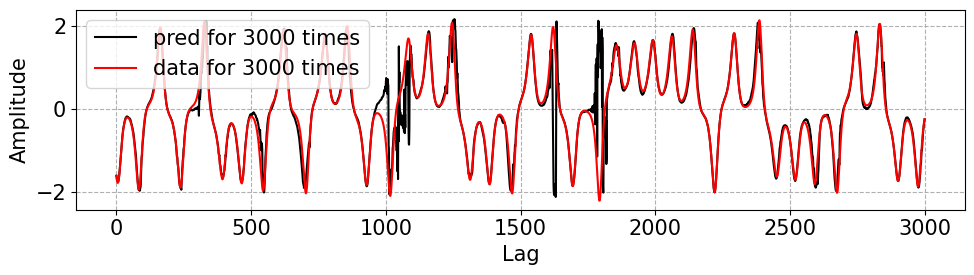

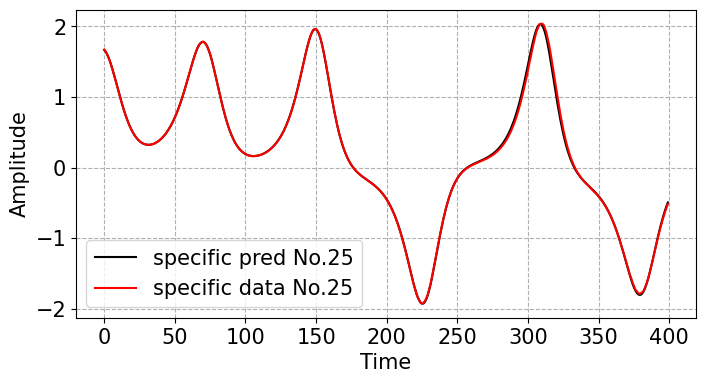

CPU times: user 5min 33s, sys: 2.09 s, total: 5min 35s
Wall time: 5min 39s


In [9]:
# @title Test phase

%%time

data_delay = np.zeros((T_train+T_test+1,dim,test_num), dtype=float)

#Test Data Preprocessing

for t in range(test_num):

       for i in range(dim):

           data_delay[:,i,t] = data[T_0+t-T_train-i*lag
                                        :T_0+t+T_test-i*lag+1]


test_Y = np.zeros((T_test,test_num))
test_D = np.zeros((T_test,test_num))
tentative_test_Y=np.zeros((T_test,dim,test_num))


##Generation of cell vector c_conti at the final time, generated in the length of cynchro_len

x_conti = None
for t in range(test_num):


    X_XT, D_XT,c_conti =  train(data_delay[T_train-synchro_len :T_train,:,t], \
                                data_delay[T_train-synchro_len+1:T_train+1,:,t],np.zeros(N_x),synchro_len,Wdatain,Wdataforget,
                                        N_x,dim,0,biasforget_scale)


    #Prediction


    tentative_test_Y[:,:,t] = run(data_delay[T_train:,:,t],c_conti,Wdatain,Wdataforget,
                                  Wout,T_test,biasforget_scale)

    test_Y[:,t] = tentative_test_Y[:,0,t]
    test_D[:,t] = data_delay[T_train+1
                             :T_train+T_test+1,0,t]

    #Removing blowup Solution from Prediction
    test_Y[np.abs(tentative_test_Y[:, 0, t]) > 5, t] = np.nan


#################
#Model evaluation
#################

test_Y_cor = [0]*test_num
data_delay_cor = [0]*test_num


for t in range(test_num):

    test_Y_cor[t] = test_Y[T_test-1,t]
    data_delay_cor[t] = test_D[T_test-1,t]


test_Y_cor = np.array(test_Y_cor)
data_delay_cor = np.array(data_delay_cor)

# Removing blowup Solution from model evaluation
mask = (~np.isnan(test_Y_cor)) & (~np.isnan(data_delay_cor))

# Calculate the autocorrelation coefficient
mae = MAE(test_Y_cor[mask],data_delay_cor[mask])
######################
#Visualization
######################

print("MAE:", mae)
print("forecast period:", T_test)

fig = plt.figure(figsize=(10,3), dpi=100)
plt.rcParams["font.size"] = 15
plt.grid(which='major', linestyle='--', axis='both')
plt.xlabel("Lag")
plt.ylabel("Amplitude")
plt.plot(test_Y_cor[:], color = "black",label=f"pred for {test_num} times")
plt.plot(data_delay_cor[:], color = "red",label=f"data for {test_num} times")
plt.legend()#loc='lower right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(test_Y[:,T_fix], color = "black",label=f"specific pred No.{T_fix}")
plt.plot(test_D[:,T_fix], color = "red",label=f"specific data No.{T_fix}")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()